### General functions

In [39]:
## Standard imports
import numpy as np
import random
import matplotlib.pyplot as plt
import skimage.io, skimage.util, scipy.ndimage
import skimage.morphology, skimage.transform
from PIL import Image

%matplotlib inline

def show_image(img, title="untitled", cmap="gray", **kwargs):
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation="nearest", **kwargs)
    plt.axis("off")
    plt.title(title)

def reshape(img):
    return np.reshape(img, (image_width, image_height))

def reformat(img):
    formatted = (img).astype('uint16')
    return Image.fromarray(formatted)

def plot_results(input_imgs, output_imgs, labels, cmap='gist_yarg'):
    fig = plt.figure(figsize=(15, 15))
    rn = 8
    for i in range(1, 6):
        print(labels[i+rn])
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(reshape(input_imgs[i+rn]), cmap=cmap)
        ax.axis('off')

    for i in range(1, 6):
        ax = fig.add_subplot(2, 5, i)
        plt.imshow(reshape(output_imgs[i+rn]), cmap=cmap)
        ax.axis('off') 

def center_crop(img, size=200):
    to_crop = (img.shape[0]-size)/2
    image_resized = skimage.util.crop(img, (to_crop, to_crop))
    return image_resized

# normalise 16-bit TIF image
def normalise(img):
    return img / 65535.0

### Read and resize dataset

#### Processing helper functions

In [40]:
def even_round(num):
    return round(num/2.)*2

# need to find a way to shuffle this pairwise!
def dataset_split(dataset, labels, test_size=0.2):
    test_size = even_round(len(dataset)*test_size)
    x_train, x_test = dataset[:-test_size], dataset[-test_size:]
    y_train, y_test = labels[:-test_size], labels[-test_size:]
    return x_train, x_test, y_train, y_test

def filenames_to_labels(filenames, folder="/Users/Leonore/Documents/Workspace/l4proj/data/processed/"):
    # 0: unstimulated
    # 1: OVA
    # 2: ConA
    # 3: empty
    labels = []
    DMSO = []
    for file in filenames:
        # file format: folder/CKX - L - 00(...)
        file = file.split("(")[0].replace(folder, '')
        # get letter for DMSO indices
        letter = file.split('-')[1].strip()
        label = file[-2:].strip()
        ck = file[:4]
        if ck == "CK19":
            if label in ["5", "8", "11", "15", "18", "21"] and letter in ["N", "O", "P"]:
                DMSO.append(len(labels))
            if label in ["3", "4", "5", "6", "7", "8", "24"]:
                label = 0
            elif label in ["9", "10", "11", "13", "14", "15", "23"]:
                label = 1
            elif label in ["16", "17", "18", "19", "20", "21", "22"]:
                label = 2
            else:
                label = 3
        elif ck == "CK21" or ck == "CK22":
            if label in ["02", "03", "04", "05", "06", "07", "08", "09", "10", "11"]:
                label = 0
            elif int(label) in range(14, 24):
                label = 2
            else:
                label = 3
            if label != 3 and letter in ["H", "P"]:
                DMSO.append(len(labels))
        else:
            print("No CK found")
        labels.append(label)
    # set(labels) = {0, 1, 2, 3}
    # DMSO = indices of data being DMSO
    return labels, DMSO

def read_folder_filenames(folder):
    return [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f[0] != '.']

In [41]:
# resize images
# read images into arrays
# read resized images back into folder for future use

import os
from skimage.io import imread, imsave
from skimage.transform import rescale, resize, downscale_local_mean

image_width = 200
image_height = 200

def resize_images(folder='/Users/Leonore/Documents/Workspace/l4proj/data/raw/', 
                  dst="/Users/Leonore/Documents/Workspace/l4proj/data/processed/CK22/"):
    filenames = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for file in filenames:
        if not os.path.exists(os.path.join(dst, file.replace(folder, ''))):
            try:
                image = skimage.io.imread(file)
                image_resized = center_crop(image, 200)
                img = reformat(image_resized)
                img.save(dst + file.replace(folder, ''))
            except Exception as e:
                print(e)
                print("{} is causing issues".format(file))

def images_to_dataset(folder="/Users/Leonore/Documents/Workspace/l4proj/data/processed/"):
    filenames = []
    for ck in ["CK19", "CK21", "CK22"]:
        filenames.extend(read_folder_filenames(folder+ck))
    filenames = sorted(filenames)
    dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)
    i = 0
    for file in filenames:
        try:
            image = skimage.io.imread(file)
            dataset[i] = normalise(image)
        except Exception as e:
            print(e)
            print("{} is causing issues".format(file))
        i += 1
    return dataset, filenames 

In [ ]:
## DON'T NEED TO RUN THIS ALL THE TIME!
resize_images()

In [42]:
dataset, filenames = images_to_dataset()

In [43]:
labels, DMSO = filenames_to_labels(filenames)

In [44]:
DMSO_dataset = np.ndarray(shape=(len(DMSO), image_width, image_height), dtype=np.float32)
DMSO_labels = []
i = 0
for index in DMSO:
    DMSO_dataset[i] = dataset[index]
    DMSO_labels.append(labels[index])
    i += 1

In [45]:
# x_train and x_test need to be kept in same order 
# as we need to do pairwise overlap calculations
x_train, x_test, y_train, y_test = dataset_split(dataset, labels, test_size=0.2)

x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

### Build autoencoder model

In [46]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_height, image_width, 1))  # adapt this if using `channels_first` image data format

x =  Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
#encoded = x

#x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x =  Conv2D(32, (5, 5), activation='relu', padding='same')(x)
# this will help going back the original image dimensions
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), padding='same')(x)

In [47]:
model = Model(input_img, decoded)
encoder = Model(input_img, encoded)

In [ ]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
#model.fit(x_train, x_train, epochs=50, batch_size=50)

In [48]:
encoded_imgs = encoder.predict(x_train)
decoded_imgs = model.predict(x_train)

In [34]:
set(DMSO_labels)

{0, 1, 2}

1
2
2
2
2


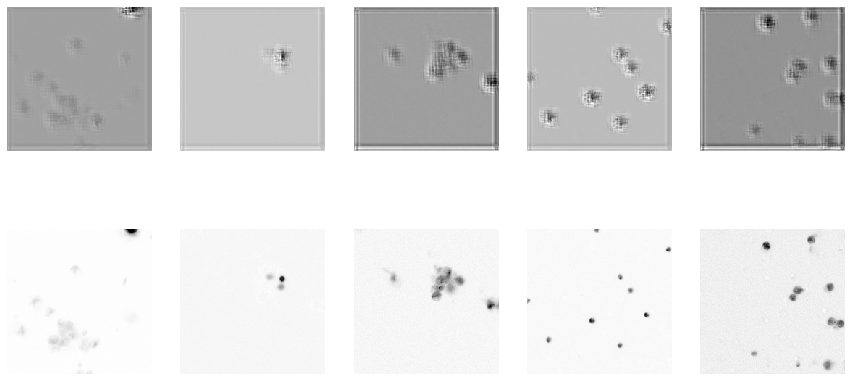

In [49]:
plot_results(x_train, decoded_imgs, y_train)

0
0
0
0
0


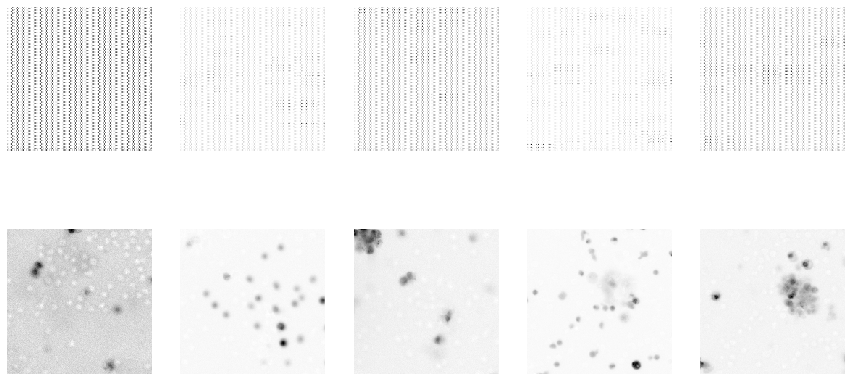

In [31]:
plot_results(x_test, encoded_imgs, y_test, cmap="gist_yarg")

### Calculate overlap between images

In [50]:
# calculate overlap between t-cell and dendritic cell
# according to stimulation
# incl. compute labels for each 

def calculate_overlap(imgs, labels):
    idx, y = 0, 0
    overlaps = np.ndarray(shape=(len(imgs)//2, image_width*image_height), dtype=np.float32)
    overlap_labels = []
    while idx < len(imgs)-1:
        tcell = imgs[idx]
        dcell = imgs[idx+1]
        #o = reshape(np.abs(dcell-tcell))
        o = np.abs(dcell-tcell)
        overlaps[y] = o
        overlap_labels.append(labels[y])
        idx += 2
        y += 1
    return overlaps, overlap_labels

x_overlap, y_overlap = calculate_overlap(encoded_imgs, y_train)
#overlap, _ = calculate_overlap(x_test, y_test)

0
0
0
1
1


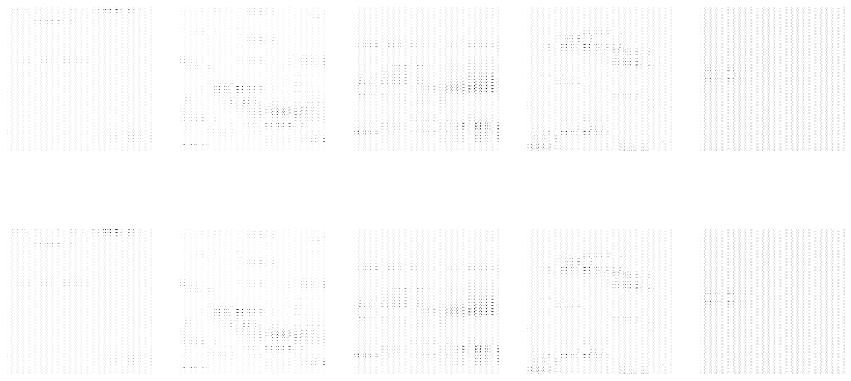

In [40]:
plot_results(x_overlap, x_overlap, y_train)

### TSNE code on own dataset

In [17]:
RS = 20191458

In [51]:
# https://www.datacamp.com/community/tutorials/introduction-t-sne
from sklearn.manifold import TSNE

tsne = TSNE(random_state=RS).fit_transform(x_overlap)

In [57]:
x_overlap

array([[0.00015334, 0.        , 0.00019485, ..., 0.        , 0.00076548,
        0.0005155 ],
       [0.00010539, 0.        , 0.00015774, ..., 0.        , 0.00068286,
        0.00043647],
       [0.00011348, 0.        , 0.00016762, ..., 0.        , 0.00072793,
        0.00049554],
       ...,
       [0.00028016, 0.        , 0.0003825 , ..., 0.        , 0.00180873,
        0.00122928],
       [0.00032664, 0.        , 0.00042262, ..., 0.        , 0.00163959,
        0.00109751],
       [0.00029711, 0.        , 0.00047524, ..., 0.        , 0.00171804,
        0.0011394 ]], dtype=float32)

(<Figure size 576x576 with 1 Axes>,
 [Text(4.975341, -10.336546, '0'),
  Text(-12.279524, 24.514067, '1'),
  Text(4.2586923, -9.231358, '2'),
  Text(4.6639204, -9.599739, '3')])

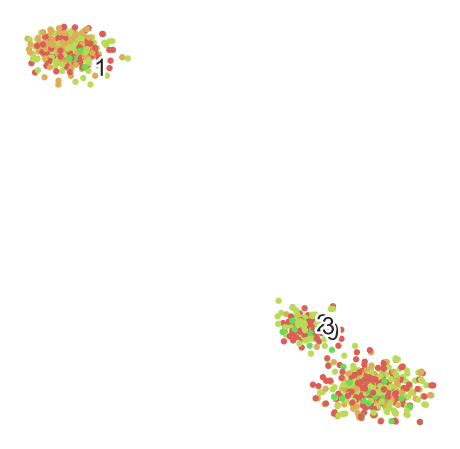

In [60]:
scatter(tsne, y_overlap)

In [31]:
x_reshaped = np.reshape(x_train, (1668, 40000))

In [34]:
not_encoded_clusters = TSNE(random_state=RS, perplexity=20).fit_transform(x_reshaped)

/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(<Figure size 576x576 with 1 Axes>,
 [Text(-5.817006, -4.466056, '0'),
  Text(-10.785108, -3.3938224, '1'),
  Text(-5.5704546, -4.2341223, '2'),
  Text(10.545581, -0.89568675, '3'),
  Text(nan, nan, '4'),
  Text(nan, nan, '5'),
  Text(nan, nan, '6'),
  Text(nan, nan, '7'),
  Text(nan, nan, '8'),
  Text(nan, nan, '9')])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


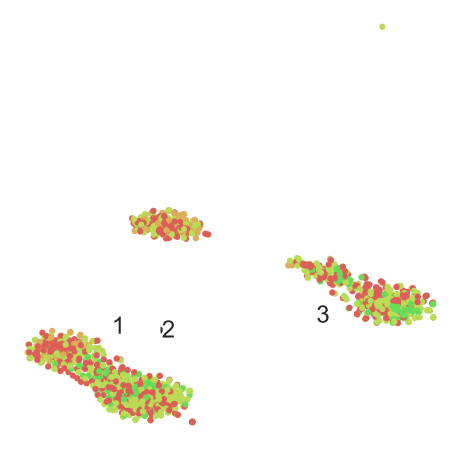

In [35]:
scatter(not_encoded_clusters, y_train)

### View filters; code snippets

In [ ]:
num_classes

In [ ]:
d1 = np.reshape(decoded_imgs[0], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))filters, biases = model.layers[1].get_weights()

In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:,:,:,i]
    #plt.figure()
    #plt.imshow(f[:,:,0], cmap='gray')
    ix+=1

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

In [ ]:
# redefine model to output right after the first hidden layer
feature_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
sample = np.expand_dims(x_train[44], axis=0)

In [ ]:
feature_maps = feature_model.predict(sample)

In [ ]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

In [ ]:
# plot the feature maps for each layer 
encoding_idx = [1, 3, 5]
outputs = [model.layers[i].output for i in encoding_idx]
feature_model = Model(inputs=model.inputs, output=outputs)
feature_maps = feature_model.predict(sample)
square = 4
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            plt.figure()
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.show()

In [ ]:
# plot the decompressed images from each layer
decoding_idx = [7, 9, 11]
outputs = [model.layers[i].output for i in decoding_idx]
decode_model = Model(inputs=model.inputs, outputs=outputs)
output_maps = decode_model.predict(sample)
square = 8
for out in output_maps:
    ix = 1
    for _ in range(square):
        plt.figure()
        plt.imshow(out[0, :, :, ix-1], cmap='gray')
        ix+=1

### Run own code on MNIST dataset

In [22]:
import numpy as np
import pandas as pd

from keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

RS = 20191458

In [59]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    
    colors = np.array(colors)
    
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(4):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [55]:
DMSO_proj = TSNE(random_state=RS,perplexity=20).fit_transform(x_overlap)

/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(<Figure size 576x576 with 1 Axes>,
 [Text(-22.992737, 42.686985, '0'),
  Text(26.963799, -85.351395, '1'),
  Text(8.416055, -22.263504, '2'),
  Text(nan, nan, '3'),
  Text(nan, nan, '4'),
  Text(nan, nan, '5'),
  Text(nan, nan, '6'),
  Text(nan, nan, '7'),
  Text(nan, nan, '8'),
  Text(nan, nan, '9')])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


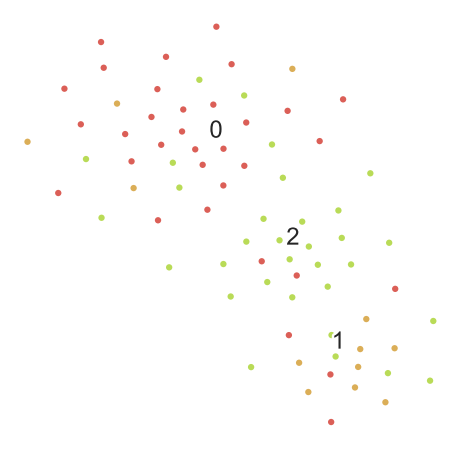

In [56]:
scatter(DMSO_proj, y_overlap)

In [36]:
(x_train, y_train), (x_test, _) = mnist.load_data()

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [37]:
x_train.shape

(60000, 28, 28)

In [13]:
compressed_digits = encoder.predict(x_train)

In [ ]:
plot_results(x_train, compressed_digits, y_train)

In [15]:
x_sample, y_sample = compressed_digits[:1000], y_train[:1000]

In [16]:
digits_proj = TSNE(random_state=RS).fit_transform(x_sample)

(<Figure size 576x576 with 1 Axes>,
 [Text(-23.434824, -24.07652, '0'),
  Text(0.8921342, 36.784325, '1'),
  Text(-3.4372888, -14.56851, '2'),
  Text(-18.846968, -2.4877715, '3'),
  Text(24.522135, -7.741519, '4'),
  Text(-12.719883, 4.7274294, '5'),
  Text(2.67167, -32.721523, '6'),
  Text(25.147923, 17.10795, '7'),
  Text(-26.502972, 13.967726, '8'),
  Text(21.978443, 4.1691303, '9')])

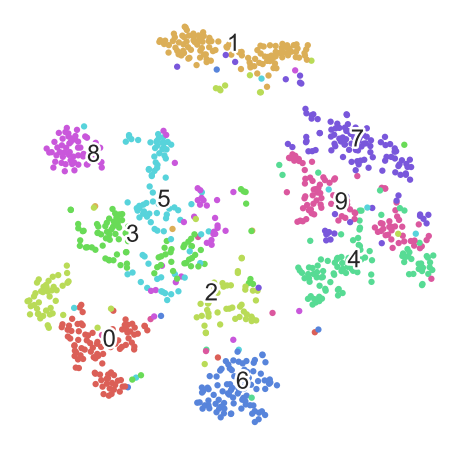

In [18]:
scatter(digits_proj, y_sample)